In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.integrate import solve_ivp
import gymnasium as gym
import cantera as ct
import numpy as np
from scipy.integrate import solve_ivp
import datetime as dt
from stable_baselines3 import DQN
# import dummy env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from datetime import datetime


In [2]:

def cantera_integration(mechanism_file, fuel, phi, temperature, pressure, residence_time, species_to_track, num_points=1000):
    gas = ct.Solution(mechanism_file)
    oxidizer = {'O2': 1, 'N2': 3.76}
    gas.set_equivalence_ratio(phi=phi, fuel=fuel, oxidizer=oxidizer)
    gas.TP = temperature, pressure

    reactor = ct.ConstPressureReactor(gas)
    network = ct.ReactorNet([reactor])

    times = np.linspace(0, residence_time, num_points)
    temperatures = []
    species_profiles = {spec: [] for spec in species_to_track}

    start_time = dt.datetime.now()
    for time in times:
        network.advance(time)
        temperatures.append(reactor.T)
        for spec in species_to_track:
            species_profiles[spec].append(reactor.thermo[spec].X)
    
    print(f"Cantera integration simulation took {(dt.datetime.now() - start_time).microseconds} microseconds")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    ax1.plot(times, temperatures)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature profile')

    for spec in species_to_track:
        ax2.plot(times, species_profiles[spec], label=spec)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Mole fraction')
    ax2.set_title('Species profiles')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    return times, temperatures, species_profiles

def simulate_combustion(fuel, mechanism_file, species_to_track, integrator, T_initial, P_initial, equivalence_ratio, t_end, num_points=100, rtol=1e-6, atol=1e-15):
    gas = ct.Solution(mechanism_file)
    print(f'Number of species: {gas.n_species}')
    print(f'Number of reactions: {gas.n_reactions}')
    
    gas.set_equivalence_ratio(equivalence_ratio, fuel, {'O2': 1, 'N2': 3.76})
    gas.TP = T_initial, P_initial

    y0 = np.hstack((gas.Y, gas.T))
    print(y0)

    def derivatives(t, y, gas):
        gas.Y = y[:-1]
        gas.TP = y[-1], gas.P
        dydt = np.zeros_like(y)
        r = gas.net_production_rates
        rho = gas.density
        dydt[:gas.n_species] = r * gas.molecular_weights / rho
        dydt[-1] = - np.dot(gas.partial_molar_enthalpies, r) / (rho * gas.cp_mass)
        return dydt

    
    times = np.linspace(0, t_end, num_points)
    print(f"Integrating using {integrator}")
    sol_start_time = dt.datetime.now()
    solution = solve_ivp(derivatives, [0, t_end], y0, method=integrator, args=(gas,), dense_output=True, rtol=rtol, atol=atol)
    print(f"Integration took {(dt.datetime.now() - sol_start_time).seconds} seconds")    
    temperatures = []
    species_profiles = {spec: [] for spec in species_to_track}
    
    start_time = dt.datetime.now()
    print(f"Extracting solution at {num_points} points")
    for time in times:
        y = solution.sol(time)
        gas.Y = y[:-1]
        gas.TP = y[-1], gas.P
        temperatures.append(gas.T)
        for spec in species_to_track:
            species_profiles[spec].append(gas[spec].X[0])
    print(f"Extraction took {(dt.datetime.now() - start_time).seconds} seconds")
    
    print(f"Combustion simulation took {(dt.datetime.now() - start_time).seconds} seconds")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    ax1.plot(times, temperatures)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature Profile Using ' + integrator)
    
    for spec in species_to_track:
        ax2.plot(times, species_profiles[spec], label=spec)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Mass Fraction')
    ax2.set_title('Species Mass Fraction Profiles Using ' + integrator)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return temperatures, species_profiles



In [ ]:
c02 = env.species_profiles['CO2']
temp = env.temperatures
print(len(c02))
print(len(temp))

species = [env.species_profiles[speci] for speci in env.species_to_track]
species = np.array(species)
print(species.shape)

In [ ]:
all_species = np.hstack((species, temp))
print(all_species.shape)

In [ ]:
env.reference_solution.shape

In [ ]:
print(ct.__version__)

Cantera integration simulation took 128315 microseconds


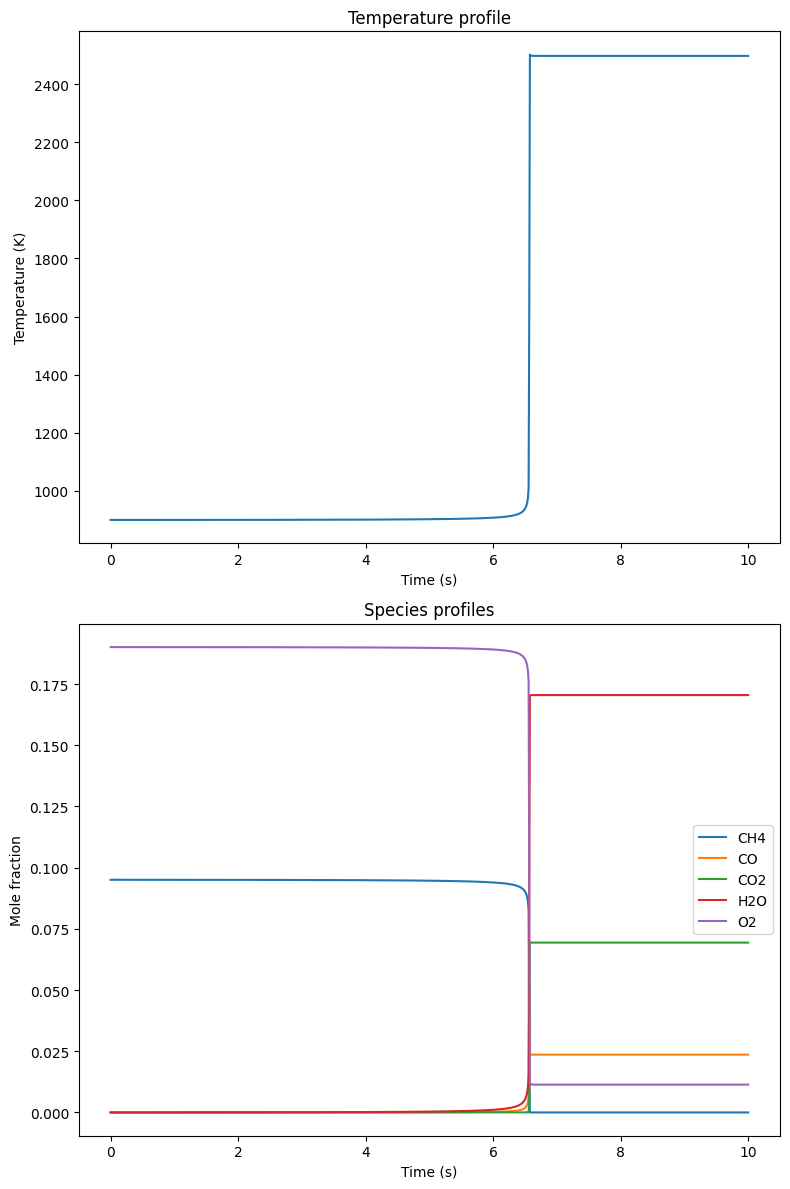

In [4]:
# Parameters
mechanism_file = '/Users/elotech/Documents/CODES/SCI-ML/integrator_rl/mechanism_files/ch4_53species.yaml'
fuel = 'CH4'
phi = equivalence_ratio = 1.0
temperature = T_initial = 900  # K
pressure = P_initial = ct.one_atm  # atm
residence_time = 10  # s
species_to_track = ['CH4', 'CO', 'CO2', 'H2O', 'O2']
num_points = 1000

# Run Cantera Integration
times, temperatures, species_profiles = cantera_integration(mechanism_file, fuel, phi, temperature, pressure, residence_time, species_to_track, num_points)


In [ ]:

# Run Combustion Simulation with Integrator
integrator = 'BDF'
rtol = 0.0001
atol = 1e-8
num_points = 1000
t_end = 1

temperatures, species_profiles = simulate_combustion(fuel, mechanism_file, species_to_track, integrator,
                                                     T_initial, P_initial, equivalence_ratio, t_end, num_points=num_points, rtol=rtol, atol=atol)


In [ ]:
import cantera as ct
import numpy as np
from scipy.integrate import solve_ivp
import datetime as dt

def solve_with_scipy(gas, method, time, dt_cfd, rtol=1e-6, atol=1e-15):
    y0 = np.hstack((gas.Y, gas.T))
    
    def derivatives(t, y):
        gas.Y = y[:-1]
        gas.TP = y[-1], gas.P
        dydt = np.zeros_like(y)
        r = gas.net_production_rates
        rho = gas.density
        dydt[:gas.n_species] = r * gas.molecular_weights / rho
        dydt[-1] = np.dot(gas.partial_molar_enthalpies, r)
        return dydt
    
    solution = solve_ivp(derivatives, [time, time + dt_cfd], y0, method=method, rtol=rtol, atol=atol)
    return solution.y[:-1, -1], solution.y[-1, -1], gas.P

mechanism_file = 'mechanism_files/ethane_mech.yaml'
fuel = 'C2H6'
phi = equivalence_ratio = 1.0
temperature = T_initial = 900  # K
pressure = P_initial = ct.one_atm  # atm
t_end = 2
t_start = 0
dt_cfd = 0.002
num_points  = int(t_end / dt_cfd)
print(f"Number of points: {num_points}")
method = 'RK45'
rtols = [1e-4, 1e-6, 1e-9]
atol = 1e-15

gas = ct.Solution(mechanism_file)
gas.set_equivalence_ratio(equivalence_ratio, fuel, {'O2': 1, 'N2': 3.76})
gas.TP = T_initial, P_initial

species_to_track = ['C2H6', 'O2', 'CO2', 'H2O']  # Example species to track, modify as needed

start_time = dt.datetime.now()
temperatures = []
species_profiles = {spec: [] for spec in species_to_track}
times = np.linspace(t_start, t_end, num_points)

for time in times:
    
    rtol = 1e-4 #np.interp(time, [t_start, t_end], [rtols[0], rtols[-1]])
    #print(f"Time: {time}, RTOL: {rtol}")
    
    try:
        y, T, P = solve_with_scipy(gas, method, time, dt_cfd, rtol=rtol, atol=atol)
    except ct.CanteraError as e:
        print(f"Warning: CanteraError at time {time}: {e}")
        break  # Or handle the error in a different way

    gas.Y = y
    gas.TP = T, P

    # Preventing unphysical temperatures
    if gas.T < 300:  # Example threshold
        gas.TP = 300, gas.P

    temperatures.append(gas.T)
    for spec in species_to_track:
        species_profiles[spec].append(gas[spec].X[0])

end_time = dt.datetime.now()
print(f"Simulation completed in {end_time - start_time}")

# The results are stored in temperatures and species_profiles
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.plot(times, temperatures)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Temperature Profile Using ' + integrator)

for spec in species_to_track:
    ax2.plot(times, species_profiles[spec], label=spec)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Mass Fraction')
ax2.set_title('Species Mass Fraction Profiles Using ' + integrator)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
from integrator_rl import CanteraEnvII
from utils import simulation_test, compare_actions

In [ ]:
# Create and wrap the environment
mechanism_file = '/Users/elotech/Documents/CODES/SCI-ML/integrator_rl/mechanism_files/ch4_53species.yaml'
fuel = 'CH4'
phi = 1.0
T_initial = 900
P_initial = ct.one_atm
species_to_track = ['CH4', 'O2', 'CO2', 'H2O']
residence_time = 10
num_points = 200

env = CanteraEnvII(mechanism_file, fuel, phi, T_initial, P_initial, species_to_track, residence_time, num_points, debug=True)

In [ ]:
env.reference_times.shape

In [ ]:
action = 3
integrator = env.integrators[action // len(env.tolerances)]
rtol = env.tolerances[action % len(env.tolerances)]
print(f"Action: {action}, Integrator: {integrator}, RTOL: {rtol}")
env.reset()

obs, reward, done, truncated, info = env.step(action)
_ = simulation_test(env, action, render=True)

In [ ]:
# env_vec = make_vec_env(lambda: env, n_envs=1)

# best_model_path = "/Users/elotech/Documents/CODES/SCI-ML/integrator_rl/logs/best_model.zip"

# # load the best model
# model =PPO("MlpPolicy", env_vec, verbose=1)
# model = DQN.load(best_model_path, env=env_vec)

In [ ]:
actions = [0, 1, 2, 3]
compare_actions(env, actions, model=model)

In [ ]:
import pickle
import numpy as np

In [ ]:
# load the results
result_path = "/Users/elotech/Documents/CODES/SCI-ML/integrator_rl/results/20240523_103040/results.pkl"
with open(result_path, 'rb') as f:
    results = pickle.load(f)

In [ ]:
results

In [ ]:
# get all the actions 
actions = [result["action"] for result in results]
# get all the time taken
time_taken = [result["time_taken"] for result in results]
total_time = [sum(np.exp(-np.array(time))) for time in time_taken]

# # take the log of the time taken
# time_taken_log = [time  or times in time_taken]
# get all the accuracy
accuracy = [result["accuracy"] for result in results]

# get all the time indices
time_indices = [result["time_indices"] for result in results]
# get all the temperature
temperature = [result["temperature"] for result in results]

full_error = [result["full_error"] for result in results]

total_time_taken = [result["total_time"] for result in results]

In [ ]:
full_error

In [ ]:
total_time_taken

In [ ]:
# plot the results
plt.bar(actions, total_time)

In [ ]:
# plot the results using symbols rather than lines for better visualization
fig, ax = plt.subplots(1, 3, figsize=(30, 8), dpi=500)
symbols = ['o', 's', 'D', '^', 'v', 'p', 'P']
for i in [1,2,3,4]:
    ax[0].plot(time_indices[i], time_taken[i], label=f"Time taken for {actions[i]}", marker=symbols[i], markersize=5)
    ax[1].plot(time_indices[i], accuracy[i], label=f"Accuracy for {actions[i]}", marker=symbols[i], markersize=5)
    ax[2].plot(time_indices[i], temperature[i], label=f"Temperature for {actions[i]}", marker=symbols[i], markersize=5)   
ax[2].plot(np.linspace(0, env.simulation_time, env.num_points)*num_points/10, env.reference_solution[:, -1], label="Reference", linestyle='--')
ax[0].set_xlabel("Time index")
ax[0].set_ylabel("log Time taken (s)")
ax[0].set_title("Log of Time taken for different actions")
ax[0].legend()

ax[1].set_xlabel("Time index")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy for different actions")
ax[1].legend()

ax[2].set_xlabel("Time index")
ax[2].set_ylabel("Temperature (K)")
ax[2].set_title("Temperature for different actions")
ax[2].legend()


plt.tight_layout()
plt.savefig("updated_results_dqn_1e468bdf.png")
plt.show()

In [ ]:
action = 0
integrator = env.integrators[action // len(env.tolerances)]
rtol = env.tolerances[action % len(env.tolerances)]
print(f"Action: {action}, Integrator: {integrator}, RTOL: {rtol}")
env.reset()

obs, reward, done, truncated, info = env.step(action)
print(f"Reward: {reward}")

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList, BaseCallback

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def reward_function(time, k=1, tau=1):
    # Use np.clip to limit the range of the exponent to avoid overflow
    exponent = np.clip(k * (time - tau), -700, 700)
    return 2 * (1 / (1 + np.exp(exponent))) - 1

# Example usage:
times = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
rewards = [reward_function(t, k=1, tau=1) for t in times]
print(rewards)

# Visualization
times = np.linspace(0, 10, 1000)  # Adjust the range for better visualization
rewards = [reward_function(t, k=1, tau=1) for t in times]

plt.plot(times, rewards)
plt.xlabel('Time (seconds)')
plt.ylabel('Reward')
plt.title('Reward Function')
plt.grid(True)
plt.show()


In [ ]:
times = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
logtime = np.log10(times)
print(logtime)

In [ ]:
import math

def reward_function(time, k=5):
    return math.exp(-k * time)
k=500
# Example usage:
times = [0.0002, 0.001, 0.001, 0.01, 0.1, 1]
rewards = [reward_function(t, k=k) for t in times]
print(rewards)


In [ ]:
action = 2
integrator = env.integrators[action // len(env.tolerances)]
rtol = env.tolerances[action % len(env.tolerances)]
print(f"Action: {action}, Integrator: {integrator}, RTOL: {rtol}")
env.reset()

obs, reward, done, truncated, info = env.step(action)
_ = simulation_test(env, action, render=True)

In [ ]:
env.y[-1]

In [ ]:
ct.one_atm

In [ ]:
env.gas.HPY

In [ ]:
action = 3
integrator = env.integrators[action // len(env.tolerances)]
rtol = env.tolerances[action % len(env.tolerances)]
print(f"Action: {action}, Integrator: {integrator}, RTOL: {rtol}")

obs, reward, done, truncated, info = env.step(action)
_ = simulation_test(env, action, render=True)

In [ ]:
env.render(plot_reference=True)

In [ ]:
for _ in range(1000):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    if done:
        break

In [ ]:
env.render(plot_reference=True)

In [ ]:
class CanteraEnvII(gym.Env):
    def __init__(self, mechanism_file, fuel, phi, T_initial, P_initial, species_to_track, residence_time, num_points):
        super(CanteraEnvII, self).__init__()
        
        self.mechanism_file = mechanism_file
        self.fuel = fuel
        self.phi = phi
        self.T_initial = T_initial
        self.P_initial = P_initial
        self.species_to_track = species_to_track
        self.residence_time = residence_time
        self.num_points = num_points
        
        self.integrators = ['BDF', 'LSODA']
        self.tolerances = [1e-4, 1e-6, 1e-9]
        
        self.action_space = gym.spaces.Discrete(len(self.integrators) * len(self.tolerances))
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(len(species_to_track) + 1,), dtype=np.float64)
        
        self.gas = ct.Solution(mechanism_file)
        self.reference_solution = self.calculate_reference_solution()
        self.reset()

    def step(self, action):
        integrator = self.integrators[action // len(self.tolerances)]
        rtol = self.tolerances[action % len(self.tolerances)]
        
        # Perform the simulation
        try:
            y, h, P = self.solve_with_scipy(self.gas, integrator, 0, self.dt_cfd, rtol, self.atol)
            self.gas.Y = y
            self.gas.HP = h, P
        except ct.CanteraError:
            reward = -100
            done = True
            return self._get_state(), reward, done, {}
        
        # Calculate reward based on time and accuracy
        current_state = self._get_state()
        reference_state = self.reference_solution[self.time_index]
        accuracy = -np.linalg.norm(current_state - reference_state)
        
        reward = -self.time_taken + accuracy
        self.time_index += 1
        done = self.time_index >= self.num_points
        truncated = False
        
        return current_state, reward, done, truncated, {"integrator": integrator, "rtol": rtol}
    
    def reset(self, seed=None):
        self.gas.set_equivalence_ratio(self.phi, self.fuel, {'O2': 1, 'N2': 3.76})
        self.gas.TP = self.T_initial, self.P_initial
        self.time_index = 0
        self.dt_cfd = self.residence_time / self.num_points
        self.t_end = self.residence_time
        self.atol = 1e-15
        return self._get_state(), {}
    
    def _get_state(self):
        state = np.hstack([self.gas[spec].X[0] for spec in self.species_to_track] + [self.gas.T])
        return state
    
    def solve_with_scipy(self, gas, method, time, dt_cfd, rtol=1e-6, atol=1e-15):
        y0 = np.hstack((gas.Y, gas.enthalpy_mass))
        
        def derivatives(t, y):
            gas.Y = y[:-1]
            gas.HP = y[-1], gas.P
            dydt = np.zeros_like(y)
            r = gas.net_production_rates
            rho = gas.density
            dydt[:gas.n_species] = r * gas.molecular_weights / rho
            dydt[-1] = np.dot(gas.partial_molar_enthalpies, r)
            return dydt
        
        start_time = dt.datetime.now()
        solution = solve_ivp(derivatives, [time, time + dt_cfd], y0, method=method, rtol=rtol, atol=atol)
        end_time = dt.datetime.now()
        
        self.time_taken = (end_time - start_time).total_seconds()
        
        return solution.y[:-1, -1], solution.y[-1, -1], gas.P

    def calculate_reference_solution(self):
        gas = ct.Solution(self.mechanism_file)
        oxidizer = {'O2': 1, 'N2': 3.76}
        gas.set_equivalence_ratio(self.phi, self.fuel, oxidizer)
        gas.TP = self.T_initial, self.P_initial

        reactor = ct.IdealGasReactor(gas)
        network = ct.ReactorNet([reactor])

        times = np.linspace(0, self.residence_time, self.num_points)
        reference_solution = []

        for time in times:
            network.advance(time)
            state = np.hstack([reactor.thermo[spec].X[0] for spec in self.species_to_track] + [reactor.T])
            reference_solution.append(state)
        
        return np.array(reference_solution)
    
    def render(self):
        # plot the temperature and species profiles in two plots in the same figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
        ax1.plot(times, temperatures)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Temperature (K)')

# Create and wrap the environment
mechanism_file = 'mechanism_files/ethane_mech.yaml'
fuel = 'C2H6'
phi = 1.0
T_initial = 1800
P_initial = ct.one_atm
species_to_track = ['C2H6', 'O2', 'CO2', 'H2O']
residence_time = 0.0001
num_points = 1000

env = CanteraEnvII(mechanism_file, fuel, phi, T_initial, P_initial, species_to_track, residence_time, num_points)




In [ ]:
env.reset()

In [ ]:
env.reference_solution.shape

In [ ]:
action = env.action_space.sample()
integrator = env.integrators[action // len(env.tolerances)]
rtol = env.tolerances[action % len(env.tolerances)]
print(f"Action: {action}, Integrator: {integrator}, RTOL: {rtol}")


In [ ]:
result = env.step(action)

In [ ]:
result

In [ ]:

env_vec = make_vec_env(lambda: env, n_envs=1)
# Define and train the RL agent
model = DQN('MlpPolicy', env_vec, verbose=1)
model.learn(total_timesteps=1000, progress_bar=True)


In [ ]:


# Test the trained agent
obs = env.reset()
for _ in range(100):
    action, _states = 
    obs, rewards, dones, info = env.step(action)
    env.render()